<a href="https://colab.research.google.com/github/OsyaginVictor/Forecasting-the-temperature-of-a-star/blob/main/Forecasting_the_temperature_of_a_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Постановка задачи

Нужно придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

Закон смещения Вина.

Закон Стефана-Больцмана.

Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Характеристики


Относительная светимость L/Lo — светимость звезды относительно Солнца.

Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

Тип звезды.

Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

Загрузим библиотеки, которые помогут нам решить задачу

In [ ]:
%pip install -q phik


from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

Note: you may need to restart the kernel to use updated packages.


Сохраним данные в переменную df. Посмотрим и изучим данные.

In [ ]:
pd.set_option('display.max_columns', None) # настроим в выоде показ всех колонок

In [ ]:
df = pd.read_csv('/datasets/6_class.csv',  index_col=0) # читаем наши данные.

In [ ]:
df.head(20)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.120,0,Red
1,3042,0.000500,0.1542,16.600,0,Red
2,2600,0.000300,0.1020,18.700,0,Red
3,2800,0.000200,0.1600,16.650,0,Red
4,1939,0.000138,0.1030,20.060,0,Red
5,2840,0.000650,0.1100,16.980,0,Red
6,2637,0.000730,0.1270,17.220,0,Red
7,2600,0.000400,0.0960,17.400,0,Red
8,2650,0.000690,0.1100,17.450,0,Red
9,2700,0.000180,0.1300,16.050,0,Red


На первый взгляд данные хорошие, без пропусков. Посмотрим на них глубже.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [ ]:
df.duplicated().sum()

0

Как мы видим,битых данных и дубликатов нет. На данном этапе в данных ничего менять не будем.

## Предобработка и анализ данных

В названиях столбцов есть пробелы и разный регистр, приведем все к общему виду.

In [ ]:
df = df.rename(columns={'Temperature (K)':'temperature',
                     'Luminosity(L/Lo)':'luminosity', 'Radius(R/Ro)':'radius',
                     'Absolute magnitude(Mv)':'abs_magnitude', 'Star type':'star_type', 'Star color':'star_color'})

In [ ]:
df.head()

,temperature,luminosity,radius,abs_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Названия изменены, теперь удобнее будет работать с данными. Теперь более детально изучим столбец star_color, посмотрим на уникальные данные

In [ ]:
print(len(df['star_color'].unique()))
print(sorted(df['star_color'].unique()))

19
['Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ', 'Blue-White', 'Blue-white', 'Orange', 'Orange-Red', 'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish', 'Yellowish', 'Yellowish White', 'white', 'yellow-white', 'yellowish']


Тут можно понять, что в названиях есть ошибки(разный регистр, пробелы и т.д).Исправим это

In [ ]:
df['star_color'] = df['star_color'].str.strip().str.lower()
print(len(df['star_color'].unique()))
print(sorted(df['star_color'].unique()))

13
['blue', 'blue white', 'blue-white', 'orange', 'orange-red', 'pale yellow orange', 'red', 'white', 'white-yellow', 'whitish', 'yellow-white', 'yellowish', 'yellowish white']


Кол-во сократилось, но это еще не все. Можно заметить что есть такие названия, как:
    'white-yellow' - 'yellow-white'
    'blue white' - 'blue-white'

In [ ]:
df = df.replace({'star_color' : { 'blue white' : 'blue-white', 'yellow-white' : 'white-yellow'}})

In [ ]:
print(len(df['star_color'].unique()))
print(sorted(df['star_color'].unique()))

11
['blue', 'blue-white', 'orange', 'orange-red', 'pale yellow orange', 'red', 'white', 'white-yellow', 'whitish', 'yellowish', 'yellowish white']


Убрали из столбца неявные дубликаты. Теперь взглянем какое кол-во у нас звезд.

In [ ]:
df['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
white-yellow            9
yellowish white         3
yellowish               3
orange                  2
whitish                 2
orange-red              1
pale yellow orange      1
Name: star_color, dtype: int64

Чтобы не удалять столбцы с маленьким кол-вом звезд и модель лучше обучалась, решил что будет лучше переименовать цвета звезд, где меньше 3-х на "other" т.к. данных и так не много.

In [ ]:
def modify_star_color(df):
    color_list = ['red', 'blue', 'blue-white', 'white', 'white-yellow']
    df['star_color'] = df['star_color'].map(lambda x: 'other' if x not in color_list else x)
    return df

In [ ]:
df = modify_star_color(df)

In [ ]:
df['star_color'].value_counts()

red             112
blue             56
blue-white       41
other            12
white            10
white-yellow      9
Name: star_color, dtype: int64

## Анализ данных

Проанализируем столбцы 'star_type','temperature','luminosity','radius','abs_magnitude'. Выведем гистограмму частот

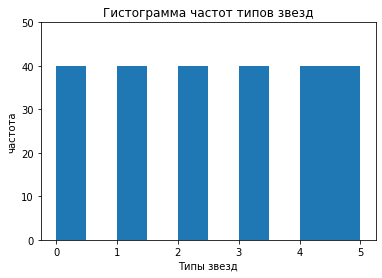

In [ ]:
df['star_type'].plot(kind = 'hist', ylim = (0, 50))
plt.xlabel('Типы звезд');
plt.ylabel('частота')
plt.title('Гистограмма частот типов звезд')
plt.show();

На этой гистограмме, можно понять, что каждый тип звезд встречается одинаково.

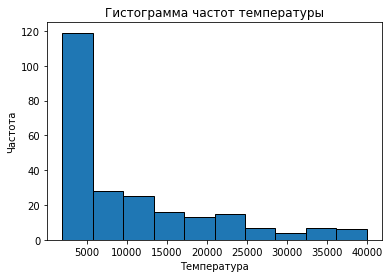

In [ ]:
#гистограмма частот столбца 'temperature'
plt.hist(df['temperature'], bins=10, edgecolor='black')

plt.title('Гистограмма частот температуры')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.show()

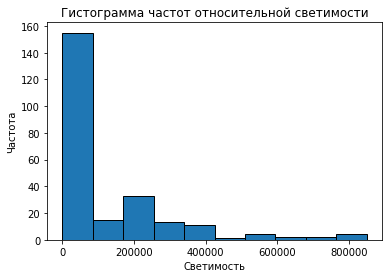

In [ ]:
#гистограмма частот столбца 'luminosity'
plt.hist(df['luminosity'], bins=10, edgecolor='black')

plt.title('Гистограмма частот oтносительной светимости')
plt.xlabel('Светимость')
plt.ylabel('Частота')
plt.show()

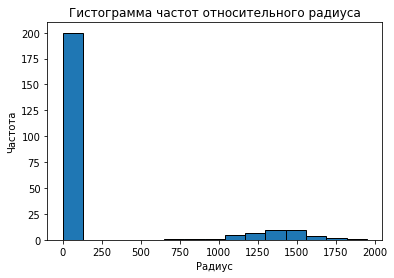

In [ ]:
#гистограмма частот столбца 'radius'
plt.hist(df['radius'], bins=15, edgecolor='black')

plt.title('Гистограмма частот относительного радиуса')
plt.xlabel('Радиус')
plt.ylabel('Частота')
plt.show()

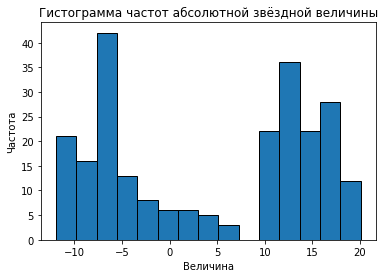

In [ ]:
#гистограмма частот столбца 'abs_magnitude'
plt.hist(df['abs_magnitude'], bins=15, edgecolor='black')

plt.title('Гистограмма частот абсолютной звёздной величины')
plt.xlabel('Величина')
plt.ylabel('Частота')
plt.show()

In [ ]:
df.describe()

,temperature,luminosity,radius,abs_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Промежуточный вывод

На данном этапе мы сделали:

    Открыли наши данные. Затем изучили их. Пропусков не было, явных дубликатов тоже.
    
    Внесли правки в названия столбцов для дальнейшего удобства пользования.
    
    Изучили столбец с цветами, убрали неявные дубликаты, объединили малое кол-во планет в одну группу.
    
    Построили графики для каждого столбца, после чего выяснили:
    
        'star_color': цвет 'red' встречается чаще всего - 112 раз, 'blue'- 56 записей.
        
        'star_type': каждый из 6 типов звезд встречается одинаковое количество раз.
        
        'temperature': принимает значения от 1939 до 40000. Медиана - 5776, стандартное отклонение - 9552.4250.
        
        'luminosity': принимает значения от 0.000080 до 849420. Медиана - 0.07050, стандартное отклонение - 179432.24494.
        
        'radius': принимает значения от 0.00840 до 1948.5. Медиана - 0.76250, стандартное отклонение - 517.15576.
        
        'abs_magnitude': принимает значения от -11.92 до 20.06. Медиана - 8.313, стандартное отклонение -10.53251.

    
    

## Подготовка данных к построению модели

В наших данных имеются:

2 категориальных столбца "star_type", "star_color"

4 столбца с числовыми данными

Для начала закодируем категориальные столбцы методом используя метод get_dummies.

In [ ]:
data_ohe = pd.get_dummies(df, drop_first=True)

In [ ]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature              240 non-null    int64  
 1   luminosity               240 non-null    float64
 2   radius                   240 non-null    float64
 3   abs_magnitude            240 non-null    float64
 4   star_type                240 non-null    int64  
 5   star_color_blue-white    240 non-null    uint8  
 6   star_color_other         240 non-null    uint8  
 7   star_color_red           240 non-null    uint8  
 8   star_color_white         240 non-null    uint8  
 9   star_color_white-yellow  240 non-null    uint8  
dtypes: float64(3), int64(2), uint8(5)
memory usage: 12.4 KB


In [ ]:
x = data_ohe.drop(['temperature'], axis=1)
y = data_ohe['temperature']

Нам предстоит решить задачу регрессии. Наш целевой признак - температура. Создадим переменные для признаков и целевого признака. Затем разобьем данные на тренировочные и тестовые выборки. После чего используем метод StandardScaler для нормализации числовых данных

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.25
)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x_train = torch.FloatTensor(x_train.tolist())
x_test = torch.FloatTensor(x_test.tolist())
y_train = torch.FloatTensor(y_train.tolist())
y_test = torch.FloatTensor(y_test.tolist())

Создадим функцию model_training, которая будет выполнять прямое и обратное распространение ошибки, а также обновлять веса модели с целью минимизации функции потерь и улучшения качества предсказаний.

In [ ]:
def model_training(train_x, train_y):
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()

    # L2-Регуляризация весов
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, train_y)) + l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

Дальше создадим функцию model_testing, которая позволит оценить качество предсказаний модели на тестовом наборе данных после каждой эпохи обучения. Это позволит контролировать процесс обучения и выявлять улучшения или переобучение модели по ходу обучения.

In [ ]:
def model_testing(epoch):
    net.eval()
    test_preds = net.forward(x_test).flatten()
    print('Epoch:', epoch)
    print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item(), '\n')
    return test_preds

Создадим функцию batch_training, которая будет использоваться для обучения модели с использованием батчей. Эта функция позволяет обучать модель пакетами данных, что может ускорить процесс обучения и улучшить сходимость модели.

In [ ]:
def batch_training(epochs_num, epoch_test):
    batch_size = 100
    num_batches = ceil(len(x_train) / batch_size)

    for epoch in range(epochs_num):
        order = np.random.permutation(len(x_train))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size

            optimizer.zero_grad()

            batch_indexes = order[start_idx:start_idx + batch_size]
            x_batch = x_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            model_training(x_batch, y_batch)
        if epoch % epoch_test == 0:
            y_pred = model_testing(epoch)
    return y_pred

Напишим функцию для отображения графика "Факт-Прогноз"

In [ ]:
def fact_forecast(y_pred):
    start = 0
    end = 15

    basic_df = y_test[start:end]
    nn_df = y_pred[start:end]

    plt.figure(figsize=(7, 7))
    plt.bar(range(start, end), nn_df.detach().numpy(), color='#06BAB6', label='Прогноз')
    plt.bar(range(start, end), basic_df, color='orange', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

Дальше инициализируем нейронную сеть прямого распространения с двумя скрытыми слоями, входной размер сети (in_neurons) равен количеству признаков в обучающем наборе данных (x_train.shape[1]).8 нейронов в первом скрытом слое, 4  нейронов во втором скрытом слое и одного нейрона в выходном слое, так как мы предсказываем только одну величину. В качестве функции активации взял nn.LeakyReLU()

In [ ]:
in_neurons = x_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 4
out_neurons = 1

class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

         # Инициализация весов и смещений для первого слоя
        nn.init.uniform_(self.fc1.weight, -2, 2)
        nn.init.zeros_(self.fc1.bias)

        # Инициализация весов и смещений для второго слоя
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0.5, std=0.7)

        # Инициализация весов и смещений для выходного слоя
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=0.5, std=0.7)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация нейросети
net = NeuralNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)

Напишем функцию init_weights, которая используется для инициализации весов нейросети. Эта функция применяется к каждому слою нейросети с помощью метода apply.

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )


net.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=9, out_features=8, bias=True)
  (ac1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (ac2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
  (ac3): LeakyReLU(negative_slope=0.01)
)

Создадим оптимизатор и функцию потерь для обучения нейросети.


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
loss = nn.MSELoss()


num_epochs = 8001

for epoch in range(num_epochs):
    model_training(x_train, y_train)
    if epoch % 1000 == 0:
        basic_nn_preds = model_testing(epoch)

Epoch: 0
RMSE = 14623.9619140625 

Epoch: 1000
RMSE = 11162.1728515625 

Epoch: 2000
RMSE = 6091.5302734375 

Epoch: 3000
RMSE = 5601.43359375 

Epoch: 4000
RMSE = 5385.41552734375 

Epoch: 5000
RMSE = 5203.43408203125 

Epoch: 6000
RMSE = 4990.37646484375 

Epoch: 7000
RMSE = 4828.08544921875 

Epoch: 8000
RMSE = 4796.82666015625 



Данный код выполняет обучение нейросети с использованием оптимизатора Adam и функции потерь MSE на протяжении указанного количества эпох. Каждую тысячу эпох выполняется валидация модели.

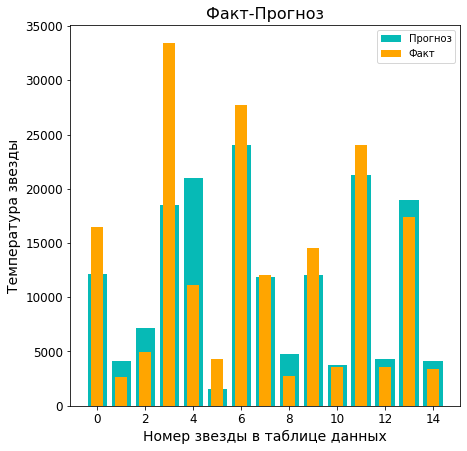

In [ ]:
fact_forecast(basic_nn_preds)

## Улучшение нейронной сети

Создадим класс нейронной сети с тремя скрытыми слоями и использовать батчи для тренировки и тестирования модели.

In [ ]:
class ImprovedlNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(ImprovedlNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация сети и весов для нее
net = ImprovedlNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(init_weights)

# Новая инициализация оптимизатора (поскольку используется новая модель)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Тренировка и тестирование нейросети с использованием батчей
batch_nn_preds = batch_training(epochs_num=15001, epoch_test=3000)

Epoch: 0
RMSE = 14626.029296875 

Epoch: 3000
RMSE = 5924.263671875 

Epoch: 6000
RMSE = 5414.41357421875 

Epoch: 9000
RMSE = 5178.57373046875 

Epoch: 12000
RMSE = 4963.04736328125 

Epoch: 15000
RMSE = 4823.11572265625 



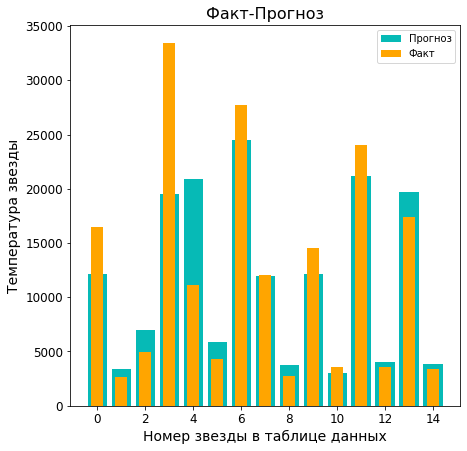

In [ ]:
fact_forecast(batch_nn_preds)

Удалось достичь значения показателя RMSE 4800.

Создадим улучшенную нейросеть с нормализацией батчей

In [ ]:
class BatchImprovedNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(BatchImprovedNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.batch1 = nn.BatchNorm1d(hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.batch2 = nn.BatchNorm1d(hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.batch3 = nn.BatchNorm1d(out_neurons)
        self.ac3 = nn.LeakyReLU()

        # Инициализация весов и смещений для первого слоя
        nn.init.uniform_(self.fc1.weight, -2, 2)
        nn.init.zeros_(self.fc1.bias)

        # Инициализация весов и смещений для второго слоя
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

        # Инициализация весов и смещений для выходного слоя
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.batch2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.batch3(x)
        x = self.ac3(x)
        return x


net = BatchImprovedNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

batch_norm = batch_training(epochs_num=5001, epoch_test=500)

Epoch: 0
RMSE = 14626.3544921875 

Epoch: 500
RMSE = 7564.04736328125 

Epoch: 1000
RMSE = 5684.10107421875 

Epoch: 1500
RMSE = 5478.46826171875 

Epoch: 2000
RMSE = 5366.6533203125 

Epoch: 2500
RMSE = 5201.18603515625 

Epoch: 3000
RMSE = 5032.22998046875 

Epoch: 3500
RMSE = 4884.12744140625 

Epoch: 4000
RMSE = 4741.5732421875 

Epoch: 4500
RMSE = 4605.71923828125 

Epoch: 5000
RMSE = 4511.736328125 



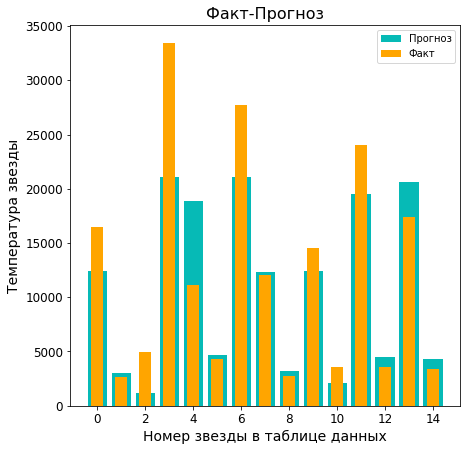

In [ ]:
fact_forecast(batch_norm)

Модель достигла значения 4500.


Создадим класс нейронной сети DropoutNeuralNet с Dropout-слоями. В конструкторе класса определяются слои нейронной сети, включая Dropout-слои, и активационные функции между ними.

In [ ]:
class DropoutNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(DropoutNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.drop1 = nn.Dropout(p=0.6)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.drop2 = nn.Dropout(p=0.6)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x



net = DropoutNeuralNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

dropout = batch_training(epochs_num=15001, epoch_test=1000)

Epoch: 0
RMSE = 14625.853515625 

Epoch: 1000
RMSE = 12982.0576171875 

Epoch: 2000
RMSE = 8563.4013671875 

Epoch: 3000
RMSE = 6834.2822265625 

Epoch: 4000
RMSE = 5997.77734375 

Epoch: 5000
RMSE = 5611.3994140625 

Epoch: 6000
RMSE = 5513.3310546875 

Epoch: 7000
RMSE = 5448.4306640625 

Epoch: 8000
RMSE = 5377.724609375 

Epoch: 9000
RMSE = 5306.63525390625 

Epoch: 10000
RMSE = 5249.84033203125 

Epoch: 11000
RMSE = 5201.67138671875 

Epoch: 12000
RMSE = 5161.74560546875 

Epoch: 13000
RMSE = 5132.07373046875 

Epoch: 14000
RMSE = 5106.70166015625 

Epoch: 15000
RMSE = 5089.42431640625 



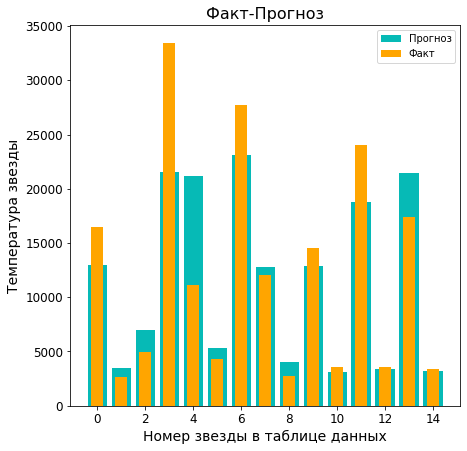

In [ ]:
fact_forecast(dropout)

Метрика RMSE достигла значения около 4880 - порог не пройден.



Нейросеть с нормализацией батчей:


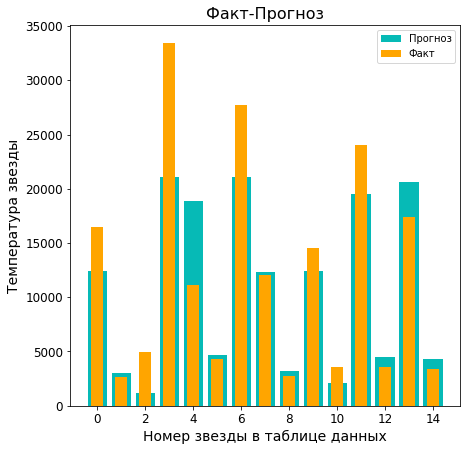

Базовая нейронная сеть:


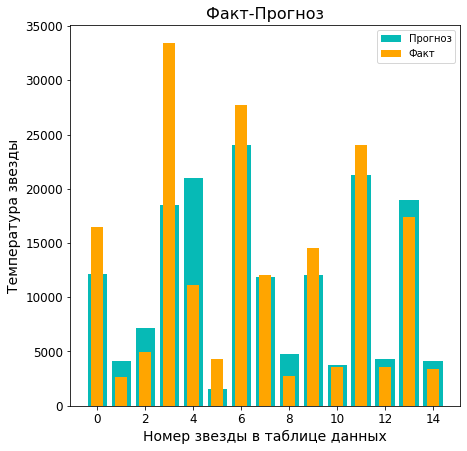

In [ ]:
print('\nНейросеть с нормализацией батчей:')
fact_forecast(batch_norm)

print('Базовая нейронная сеть:')
fact_forecast(basic_nn_preds)

## Вывод

В ходе исследовательского анализа были проанализированы количественные и категориальные данные.

Для данных были построены графики и был написан промежуточный вывод после иследовательского анализа.

Далее мы закодировали данные и произвели масштабирование. После чего данные были разделены на тренировачную и тестовую выборки.

В ходе работы нам нужно было решить задачу регрессии - предсказать температуру звезды. Для этого было построено несколько простых моделей нейронных сетей с разными архитектурами и функциями активации. Модель была обучена и проанализирована на графике "Факт - Прогноз"

На следующем шаге было создано решение с перебором параметров нейросети, включая dropout и размер батча.

Рекомендуется использовать нейросеть с использованием нормализации батчей, поскольку ее метрика ниже, а ресурсы на обучение и тестирование не столь значительны в отличие от базовой нейронной сети.